# Random Forest Classification

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [22]:
import pandas as pd
df = pd.read_csv('Datasets/drug200.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [23]:
df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

<Axes: xlabel='Drug'>

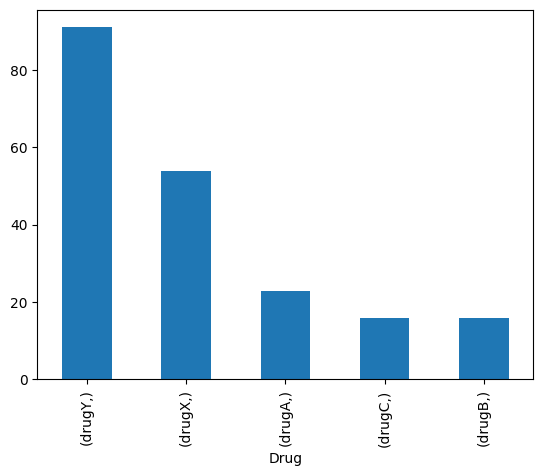

In [24]:
df[['Drug']].value_counts().plot(kind='bar')

### seperate the X and Y
- Drug ~ Age, Sex, BP, Cholesterol, Na_to_K

In [25]:
X = df.drop(columns=['Drug'])
Y = df[['Drug']]

In [26]:
from PM6func import catconsep
cat,con = catconsep(X)

In [27]:
cat

['Sex', 'BP', 'Cholesterol']

In [28]:
con

['Age', 'Na_to_K']

### seperate categorical and continuous features

In [29]:
from PM6func import catconsep
cat,con = catconsep(X)

### Preprocess Data

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [33]:
num_pipe = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                           ('scaler', StandardScaler())])
cat_pipe = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                           ('ohe', OneHotEncoder(handle_unknown='ignore'))])
pre = ColumnTransformer([
    ('num_pipe', num_pipe, con),
    ('cat_pipe', cat_pipe, cat)
])
pre

,transformers,"[('num_pipe', ...), ('cat_pipe', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [34]:
X_pre = pre.fit_transform(X)
X_pre

array([[-1.29159102,  1.28652212,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.16269866, -0.4151454 ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.16269866, -0.82855818,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.46567567, -0.85908883,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [-1.29159102, -0.28650033,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [-0.26146916, -0.6571702 ,  1.        , ...,  0.        ,
         0.        ,  1.        ]], shape=(200, 9))

In [35]:
cols = pre.get_feature_names_out()
cols

array(['num_pipe__Age', 'num_pipe__Na_to_K', 'cat_pipe__Sex_F',
       'cat_pipe__Sex_M', 'cat_pipe__BP_HIGH', 'cat_pipe__BP_LOW',
       'cat_pipe__BP_NORMAL', 'cat_pipe__Cholesterol_HIGH',
       'cat_pipe__Cholesterol_NORMAL'], dtype=object)

In [36]:
X_pre = pd.DataFrame(X_pre, columns=cols)
X_pre.head()

,num_pipe__Age,num_pipe__Na_to_K,cat_pipe__Sex_F,cat_pipe__Sex_M,cat_pipe__BP_HIGH,cat_pipe__BP_LOW,cat_pipe__BP_NORMAL,cat_pipe__Cholesterol_HIGH,cat_pipe__Cholesterol_NORMAL
0,-1.291591,1.286522,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.162699,-0.415145,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.162699,-0.828558,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,-0.988614,-1.149963,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,1.011034,0.271794,1.0,0.0,0.0,1.0,0.0,1.0,0.0


### train test split
- 70% train data
- 20% test data

In [37]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(X_pre,Y,test_size=0.3,random_state=42)
xtrain.shape

(140, 9)

In [38]:
xtest.shape

(60, 9)

### train Random Forest model with random parameters

In [41]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1,max_depth=2, min_samples_split=2, min_samples_leaf=5, criterion='gini')
model.fit(xtrain,ytrain)
model.score(xtrain,ytrain)

0.5571428571428572

In [42]:
model.score(xtest,ytest)

0.5166666666666667

### This is not a optimal score or parameters so, use
## Hyperparameter Tunning

In [49]:
params = {
    "n_estimators":[1,50,100,150,200],
    'max_depth':[5,6,7,8,9,10,11],
    'min_samples_split':[7,8,9,10,11,12],
    'criterion':['gini','entropy']
}

In [50]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier()
rscv = RandomizedSearchCV(rf, param_distributions=params, cv=5, scoring='f1_macro')
rscv.fit(xtrain,ytrain)

,estimator,RandomForestClassifier()
,param_distributions,"{'criterion': ['gini', 'entropy'], 'max_depth': [5, 6, ...], 'min_samples_split': [7, 8, ...], 'n_estimators': [1, 50, ...]}"
,n_iter,10
,scoring,'f1_macro'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [51]:
rscv.best_params_

{'n_estimators': 200,
 'min_samples_split': 12,
 'max_depth': 9,
 'criterion': 'gini'}

In [52]:
best_rf = rscv.best_estimator_
best_rf

,n_estimators,200
,criterion,'gini'
,max_depth,9
,min_samples_split,12
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [53]:
best_rf.score(xtrain,ytrain)

1.0

In [54]:
best_rf.score(xtest,ytest)

1.0

## Predict the result

In [55]:
ypred_tr = best_rf.predict(xtrain)
ypred_ts = best_rf.predict(xtest)

In [56]:
ypred_tr[0:5]

array(['drugA', 'drugY', 'drugB', 'drugY', 'drugX'], dtype=object)

In [57]:
ytrain.head()

,Drug
169,drugA
97,drugY
31,drugB
12,drugY
35,drugX


In [58]:
ypred_ts[0:5]

array(['drugX', 'drugY', 'drugX', 'drugC', 'drugY'], dtype=object)

In [59]:
ytest.head()

,Drug
95,drugX
15,drugY
30,drugX
158,drugC
128,drugY


### probability of result

In [63]:
best_rf.classes_

array(['drugA', 'drugB', 'drugC', 'drugX', 'drugY'], dtype=object)

In [62]:
best_rf.predict_proba(xtrain)[0:5]

array([[6.79556809e-01, 1.55463978e-01, 2.49010091e-02, 2.10407330e-02,
        1.19037471e-01],
       [1.88268398e-02, 6.98505935e-02, 1.92307692e-03, 5.64102564e-03,
        9.03758464e-01],
       [1.88422038e-01, 6.73465915e-01, 3.15035485e-02, 3.75810635e-02,
        6.90274358e-02],
       [2.71381579e-03, 5.26315789e-04, 1.41393305e-01, 1.41460623e-02,
        8.41220502e-01],
       [1.26852474e-02, 4.56349206e-03, 2.85256410e-03, 9.26232885e-01,
        5.36658109e-02]])

In [64]:
ypred_tr[0:5]

array(['drugA', 'drugY', 'drugB', 'drugY', 'drugX'], dtype=object)

In [67]:
imp = best_rf.feature_importances_
imp

array([0.11065473, 0.53002211, 0.00704775, 0.00855692, 0.13743222,
       0.05402943, 0.08536298, 0.03428502, 0.03260883])

<Axes: title={'center': 'Feature Importance'}>

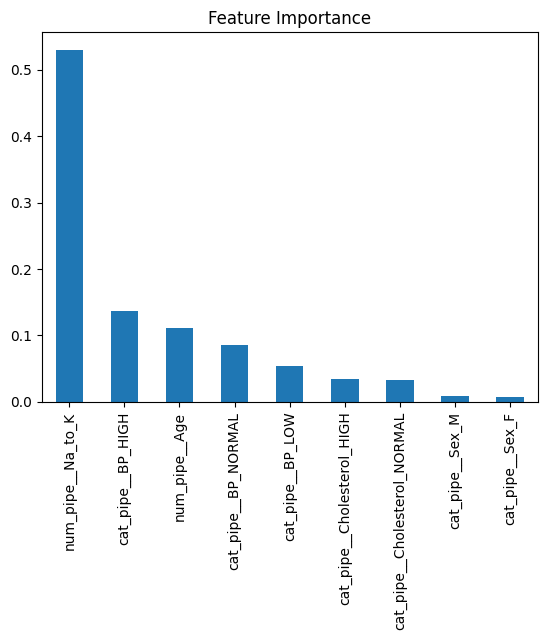

In [76]:
imp = pd.Series(imp,cols)
imp =imp.sort_values(ascending=False)
imp.plot(kind='bar', title='Feature Importance')